# Basic Statistics for Cosmology: Exercises on $H_0$

This notebook is designed as a **student exercise**.  
You will work through **Frequentist** and **Bayesian** methods to estimate the Hubble constant $H_0$ from mock data.  

👉 This is the **exercise version** (without solutions).  
The instructor has a separate notebook with solutions.

---

## Instructions
- Fill in the code cells where you see `# TODO`.
- Answer the discussion questions in markdown cells.
- Try to first attempt on your own before checking solutions.

---

## Doing SN cosmology with a synthetic dataset, using luminosity distance relation

**Key low-$z$ relations** (valid for $z\lesssim0.1$):

$$ d_L \approx \frac{cz}{H_0} \quad (\text{in Mpc}) $$
$$ \mu \equiv m - M = 5\log_{10}\!\left( \frac{d_L}{\text{Mpc}} \right) + 25 $$
Combining these: 
$$ m = M + 5\log_{10}(cz) - 5\log_{10}(H_0) + 25. $$

If $M$ is known (from external calibration), one can directly infer $H_0$. If $M$ is unknown **and** you only fit SN data, then $(M, H_0)$ are nearly perfectly degenerate at low $z$—you must supply an $M$ prior or external constraint to break the degeneracy.



## Part 1: Frequentist Statistics

### Exercise 1.1: Load and Visualize Data
Generate a very simplistic SN dataset!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple

c_km_s = 299792.458  # speed of light in km/s

def mu_from_z(z, H0):
    """Low-z luminosity distance modulus: mu = 5 log10(c z / H0 [Mpc]) + 25.
    Here c is in km/s, H0 in km/s/Mpc, so cz/H0 is in Mpc.
    """
    dL_Mpc = (c_km_s * z) / H0
    return 5.0 * np.log10(dL_Mpc) + 25.0

def mag_model(z, H0, M):
    return M + mu_from_z(z, H0)

def sigma_mu_pec(z, v_pec=300.0, H0=70.0):
    """Approximate magnitude uncertainty from peculiar velocities.
    sigma_mu ~ (5/ln(10)) * (sigma_dL/dL).
    At low z, dL ~ cz/H0, so fractional distance error from peculiar velocity sigma_v is ~ sigma_v/(cz).
    """
    frac = v_pec/(c_km_s * z)
    return (5/np.log(10)) * frac

@dataclass
class SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    z : np.ndarray
        Array of redshifts of the supernovae.
    m : np.ndarray
        Array of observed magnitudes of the supernovae.
    sigma_m : np.ndarray
        Array of total magnitude uncertainties (measurement + intrinsic + peculiar velocity).
    name : str
        Str for the name of the sample (default is "synthetic").
    """
    z: np.ndarray
    m: np.ndarray
    sigma_m: np.ndarray
    name: str = "synthetic"

def make_synthetic_sample(N=100, H0=73.0, M=-19.3, zmin=0.01, zmax=0.08,
                          sigma_meas=0.1, sigma_int=0.1, v_pec=300.0, rng=None) -> SNSample:
    """
    Generate a synthetic supernova sample for cosmological parameter estimation.

    Parameters
    ----------
    N : int
        Number of supernovae to simulate.
    H0 : float
        True Hubble constant (km/s/Mpc) used to generate the data.
    M : float
        True absolute magnitude of the supernovae.
    zmin : float
        Minimum redshift of the sample.
    zmax : float
        Maximum redshift of the sample.
    sigma_meas : float
        Measurement uncertainty in magnitudes (per SN).
    sigma_int : float
        Intrinsic scatter in magnitudes (per SN).
    v_pec : float
        RMS peculiar velocity in km/s (affects low-z distance errors).
    rng : int, np.random.Generator, or None
        Random seed or numpy random generator for reproducibility.

    Returns
    -------
    SNSample
        Dataclass containing arrays of redshift (z), observed magnitude (m), 
        total magnitude uncertainty (sigma_m), and sample name.
    """
    rng = np.random.default_rng(rng)
    z = np.sort(rng.uniform(zmin, zmax, size=N))
    mu = mu_from_z(z, H0)
    m_true = M + mu
    # per-SN error budget: measurement + peculiar velocity + intrinsic scatter
    sig_pec = sigma_mu_pec(z, v_pec=v_pec, H0=H0)
    sigma_tot = np.sqrt(sigma_meas**2 + sig_pec**2 + sigma_int**2)
    m_obs = rng.normal(m_true, sigma_tot)
    return SNSample(z=z, m=m_obs, sigma_m=sigma_tot, name="synthetic")

In [2]:
# TODO: generate and plot data with error bars

H0_true = 73.0  # True Hubble constant for synthetic data
M_true  = -19.3  # True absolute magnitude for synthetic data
zmin    = 0.01
zmax    = 0.08
N       = 200

mock_data = make_synthetic_sample(N=N, H0=H0_true, M=M_true, zmin=zmin, zmax=zmax)
z_model   = np.linspace(zmin, zmax, 400)
model     = mag_model(z_model, H0_true, M_true)

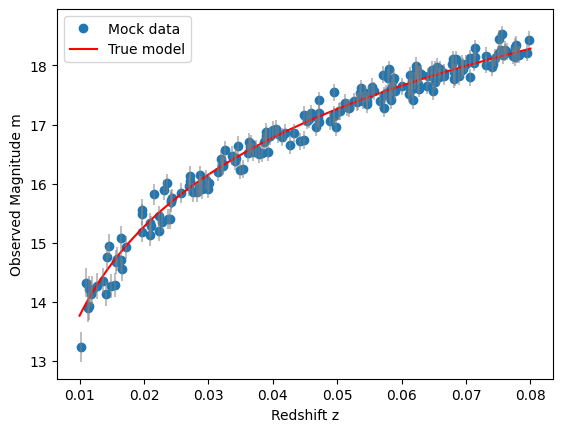

In [3]:
plt.figure()
plt.plot(mock_data.z, mock_data.m, 'o', label='Mock data')
plt.plot(z_model, model, 'r', label='True model')
plt.errorbar(mock_data.z, mock_data.m, yerr=mock_data.sigma_m, fmt='none', ecolor='gray', alpha=0.5)
plt.xlabel('Redshift z')
plt.ylabel('Observed Magnitude m')
plt.legend()
plt.show()

### Exercise 1.2: Define the χ² function
Write down the chi-square function for the model.

In [4]:
# TODO: define chi2 function
def chi2(H0, M, x, y, sigma):
    model = mag_model(x, H0, M)
    return np.sum(((y - model) / sigma) ** 2)

### Exercise 1.3: Minimize χ²
Find the best-fit parameters by minimizing χ².

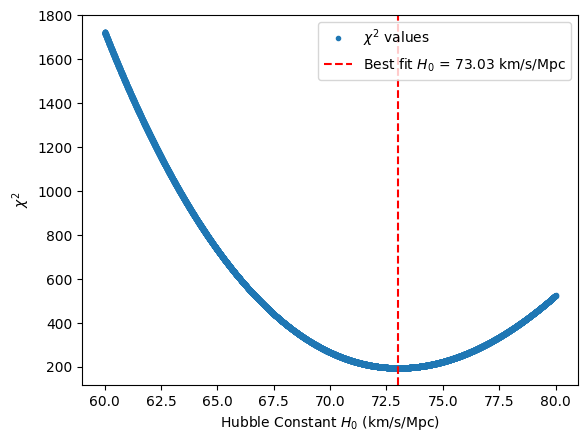

In [5]:
# TODO: use numpy or scipy to minimize chi2
def find_best_fit_H0(data, H0_array):
    chi2_tab = [chi2(H0, M_true, data.z, data.m, data.sigma_m) for H0 in H0_array]
    return H0_array[np.argmin(chi2_tab)], chi2_tab

H0_array                 = np.linspace(60, 80, 10000)
best_fit_H0, chi2_values = find_best_fit_H0(mock_data, H0_array)

plt.figure()
plt.plot(H0_array, chi2_values, '.',label=r"$\chi^2$ values")
plt.axvline(best_fit_H0, color='r', linestyle='--', label=rf"Best fit $H_0$ = {best_fit_H0:.2f} km/s/Mpc")
plt.xlabel(r"Hubble Constant $H_0$ (km/s/Mpc)")
plt.ylabel(r"$\chi^2$")
plt.legend()
plt.show()

#### TODO: say something about goodness of fit
Not perfect due to the sampling.

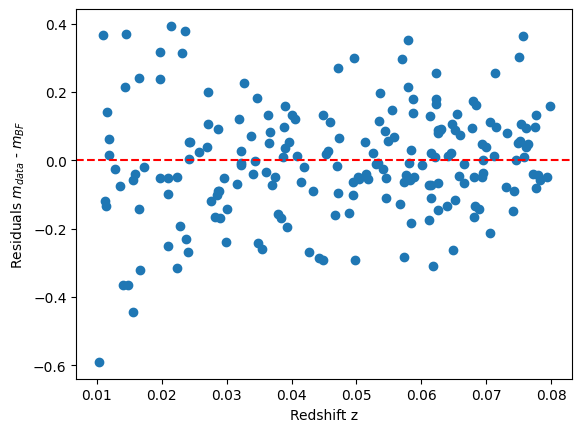

In [6]:
# TODO: plot residuals, always!

plt.figure()
best_fit_model = mag_model(mock_data.z, best_fit_H0, M_true)
residuals      = mock_data.m - best_fit_model
plt.plot(mock_data.z, residuals, 'o')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Redshift z')
plt.ylabel('Residuals $m_{data}$ - $m_{BF}$')
plt.show()

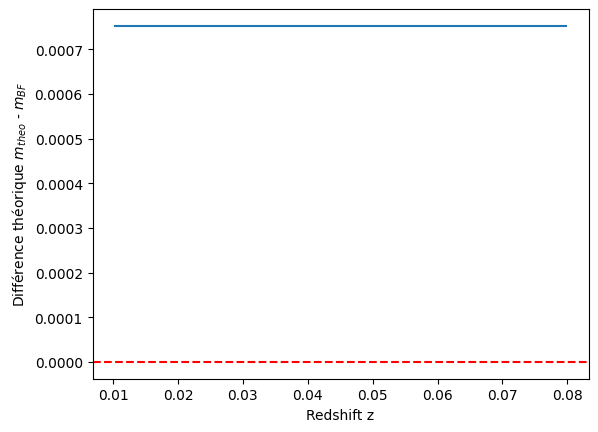

In [7]:
plt.figure()
best_fit_model    = mag_model(mock_data.z, best_fit_H0, M_true)
theoretical_model = mag_model(mock_data.z, H0_true, M_true)
residuals_theo    = theoretical_model - best_fit_model
plt.plot(mock_data.z, residuals_theo)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Redshift z')
plt.ylabel('Différence théorique $m_{theo}$ - $m_{BF}$')
plt.show()

### Exercise 1.4: Bootstrap uncertainties
Use bootstrap resampling to estimate parameter uncertainties.

In [10]:
# TODO: implement bootstrap loop, any ideas how to do this?

# The concept is to resample the data with replacement, fit each resampled dataset, and collect the best-fit parameters to estimate uncertainties.

def bootstrap_H0(sn: SNSample, M, nboot=500, rng=None):
    """
    Estimate the uncertainty in H0 by bootstrapping the SN sample.

    Parameters
    ----------
    sn : SNSample
        The supernova sample (with z, m, sigma_m arrays).
    M : float
        The assumed absolute magnitude of the supernovae.
    nboot : int, optional
        Number of bootstrap resamples (default: 500).
    rng : np.random.Generator or None, optional
        Random number generator or seed (default: None).

    Returns
    -------
    np.ndarray
        Array of best-fit H0 values from each bootstrap resample.
    """
    rng = np.random.default_rng(rng)
    H0s = []
    idx = np.arange(len(sn.z))
    H0_grid = np.linspace(50, 90, 801) # same grid as before
    for _ in range(nboot):
        # Resample SN indices with replacement
        sel = rng.choice(idx, size=len(idx), replace=True)
        # Create a new SNSample with the resampled data
        sn_b = SNSample(sn.z[sel], sn.m[sel], sn.sigma_m[sel], name=sn.name)
        # Find best-fit H0 for this resample
        hbest, chi2_vals = find_best_fit_H0(sn_b, H0_array=H0_grid)
        H0s.append(hbest)
    return np.array(H0s)

H0_bootstrap = bootstrap_H0(mock_data, M_true, nboot=10000)
h_med = np.median(H0_bootstrap)
print(f"Bootstrap median H0 = {h_med:.2f} km/s/Mpc")

Bootstrap median H0 = 73.00 km/s/Mpc


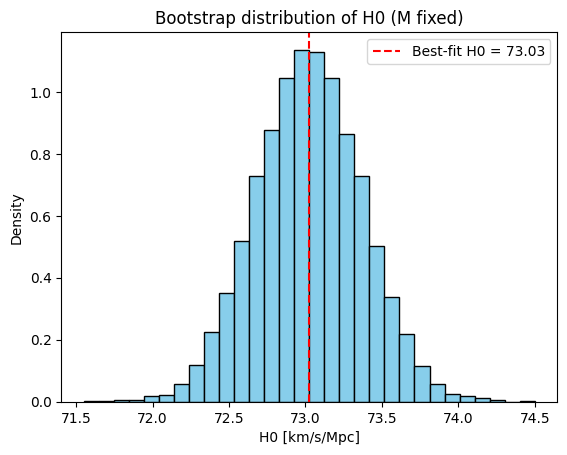

In [11]:
plt.figure()
plt.hist(H0_bootstrap, bins=30, density=True, color="skyblue", edgecolor="k")
plt.axvline(best_fit_H0, color='r', linestyle='--', label=f'Best-fit H0 = {best_fit_H0:.2f}')
plt.xlabel('H0 [km/s/Mpc]')
plt.ylabel('Density')
plt.title('Bootstrap distribution of H0 (M fixed)')
plt.legend()
plt.show()

### Exercise 1.5: p-value
Calculate a p-value from the sampled probability

In [ ]:
# TODO: let's calculate a p-value from the sampled probability

### Exercise 1.6: Compare with MLE
Explain how minimizing χ² relates to Maximum Likelihood Estimation.

👉 *Write your discussion here*

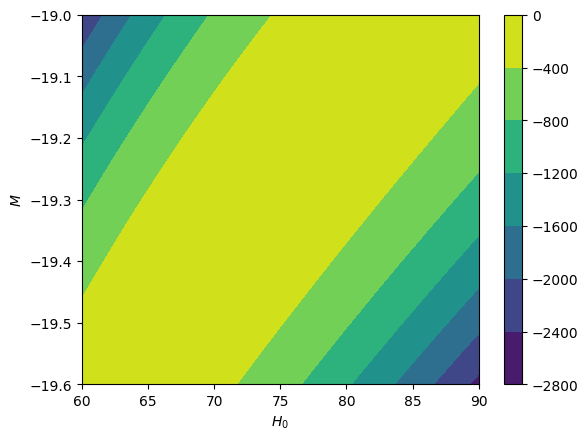

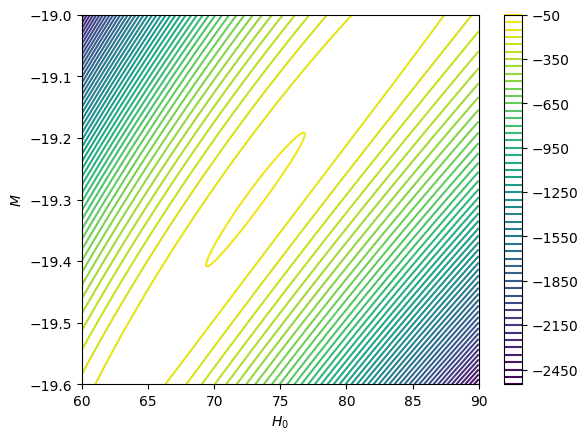

In [71]:
def minus2lnlikelihood(H0, M, x, y, sigma, M_cal=M_true, sigma_M=0.1):
    return chi2(H0, M, x, y, sigma) + (M-M_cal)**2 / sigma_M**2

def tab_log_likelihood(data, H0_array, M_array, M_cal, sigma_M):
    """ Minimize likelihood to find the best fit of (M,H0) for the data"""
    tab = np.zeros((len(M_array),len(H0_array)))
    for i in range(len(M_array)) :
        for j in range(len(H0_array)) :
            tab[i,j] = minus2lnlikelihood(H0_array[j], M_array[i], data.z, data.m, data.sigma_m, M_cal=M_cal, sigma_M=sigma_M)
    return -tab/2.

H0_array  = np.linspace(60, 90, 1000)
M_array   = np.linspace(-19.6, -19, 2000)

M_cal   = M_true
sigma_M = 0.05

log_likelihood_tab = tab_log_likelihood(mock_data, H0_array, M_array, M_cal, sigma_M)

plt.figure()
plt.contourf(H0_array, M_array, log_likelihood_tab)
plt.ylabel(r"$M$")
plt.xlabel(r"$H_0$")
plt.colorbar()
plt.show()

plt.figure()
#plt.contourf(M_array, H0_array, log_likelihood_tab)
plt.contour(H0_array, M_array, log_likelihood_tab,levels=50) # 1 et 2 sigma
plt.ylabel(r"$M$")
plt.xlabel(r"$H_0$")
plt.colorbar()
plt.show()

## Part 2: Bayesian Statistics

### Exercise 2.1: Bayes' theorem
Write Bayes' theorem and identify prior, likelihood, posterior.

👉 *Write Bayes' theorem in your own words here*

### Exercise 2.2: Compute Posterior on a Grid
Define priors and likelihood, then compute posterior on a parameter grid.

In [72]:
# TODO: implement grid posterior evaluation

def log_uniform_prior(x, x_min, x_max):
    if x_min < x < x_max:
        return 0.0
    return -np.inf

def log_gaussian_prior(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2

def log_posterior(log_likelihood, H0_log_prior, M_log_prior):
    return log_likelihood + H0_log_prior + M_log_prior

def evaluate_posterior_grid(log_likelihood_tab, H0_array, M_array):
    """ Evaluate the posterior on a grid of parameters """
    tab = np.zeros((len(M_array),len(H0_array)))
    for i in range(len(M_array)) :
        for j in range(len(H0_array)) :
            tab[i,j] = log_posterior(log_likelihood_tab[i,j], log_uniform_prior(H0_array[j], H0_array[0], H0_array[-1]), log_gaussian_prior(M_array[i], M_cal, sigma_M))
    return tab

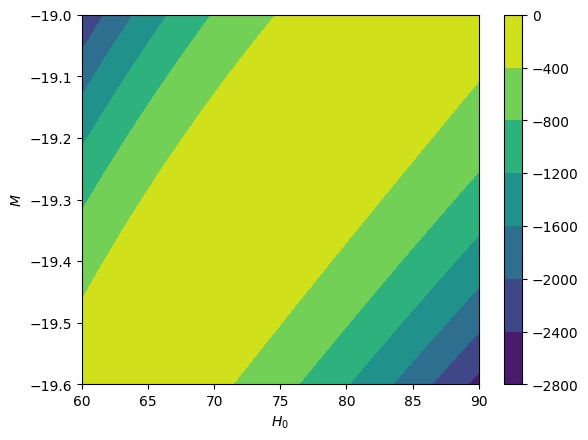

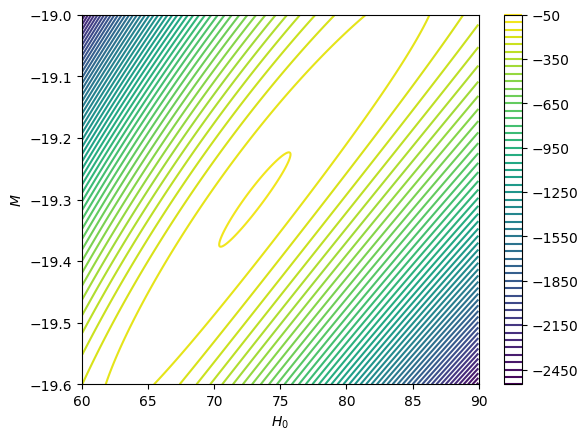

In [73]:
log_posterior_tab = evaluate_posterior_grid(log_likelihood_tab, H0_array, M_array)

plt.figure()
plt.contourf(H0_array, M_array, log_posterior_tab)
plt.ylabel(r"$M$")
plt.xlabel(r"$H_0$")
plt.colorbar()
plt.show()

plt.figure()
#plt.contourf(M_array, H0_array, log_likelihood_tab)
plt.contour(H0_array, M_array, log_posterior_tab,levels=50) # 1 et 2 sigma
plt.ylabel(r"$M$")
plt.xlabel(r"$H_0$")
plt.colorbar()
plt.show()

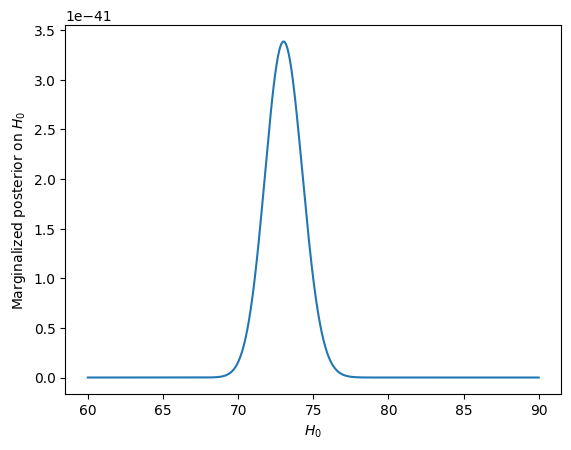

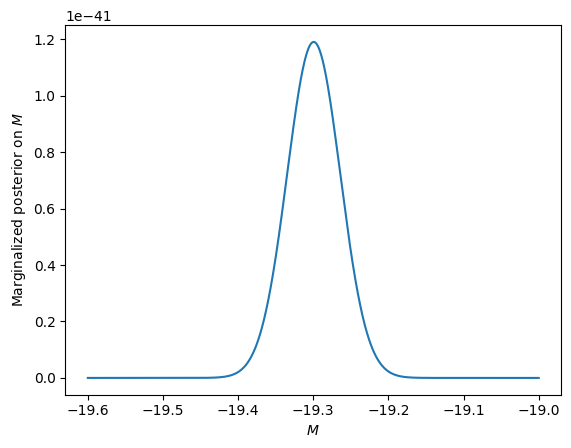

In [79]:
marginal_H0 = np.sum(np.exp(log_posterior_tab), axis=0)
plt.figure()
plt.plot(H0_array, marginal_H0)
plt.xlabel(r"$H_0$")
plt.ylabel(r"Marginalized posterior on $H_0$")
plt.show()

marginal_M = np.sum(np.exp(log_posterior_tab), axis=1)
plt.figure()
plt.plot(M_array, marginal_M)
plt.xlabel(r"$M$")
plt.ylabel(r"Marginalized posterior on $M$")
plt.show()

### Exercise 2.3: Normalize Posterior and Extract Marginal Estimates
Normalize posterior, compute marginal estimations of $H_0$ and $M$

In [1]:
# TODO: normalize posterior
# TODO: compute marginal distributions

### Exercise 2.4: Credible Interval
Compute the 68% credible interval from the posterior.

In [ ]:
# TODO: credible interval calculation

### Exercise 2.5: Compare with Frequentist Result
Compare Bayesian and Frequentist estimates of $H_0$.

👉 *Write your comparison here*

## Part 3: Re-do with `Cobaya`

Estimate $H_0$ using Cobaya and Bayesian Statistics and compare

In [84]:
def log_likelihood_for_cobaya(H0,M):
    """ Log-likelihood function for cobaya """
    return -minus2lnlikelihood(H0, M, mock_data.z, mock_data.m, mock_data.sigma_m, M_cal=M_cal, sigma_M=sigma_M)/2.

info_dict = {
    "params" : {
        'H0' : {"prior": {"min": H0_array[0], "max": H0_array[-1]}, "latex": r"H_0"},
        'M' : {"prior": {"dist": "norm", "loc": M_cal, "scale": sigma_M}, "latex": r"M"}
    },
    "likelihood" : {
        "my_sn_likelihood" : {"external": log_likelihood_for_cobaya}
    },
    "sampler" : {
        "mcmc" : {
            "Rminus1_stop" : 0.01,
            "max_tries" : 1000000
        }
    },
}

In [85]:
from cobaya.run import run
# Now we run!
updated_info, sampler = run(info_dict)

[my_sn_likelihood] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[mcmc] Initial point: H0:74.83672, M:-19.31189


[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {my_sn_likelihood: 50500.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2025-08-28 16:48:22 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 0.059
[mcmc]  - Convergence of means: R-1 = 0.205352 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 0.129
[mcmc]  - Convergence of means: R-1 = 0.049352 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 0.193
[mcmc]  

[root] *WARNING* outlier fraction 0.04 
Mean:
[ 73.0421623  -19.29915395]
Covariance matrix:
[[1.57429294e+00 4.34689826e-02]
 [4.34689826e-02 1.31291690e-03]]


<Figure size 640x480 with 0 Axes>

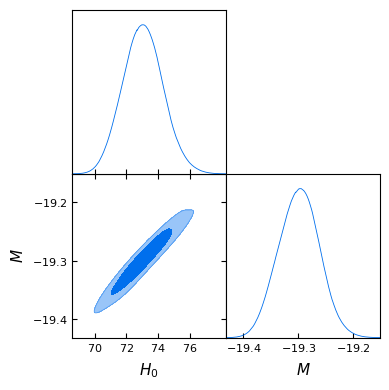

In [86]:
# Import corresponding modules from GetDist
from getdist.mcsamples import loadMCSamples, MCSamplesFromCobaya
import getdist.plots as gdplt

# Load the chains and the updated config file from the previous run
gd_sample = MCSamplesFromCobaya(updated_info, sampler.products()["sample"])

# Analyze the chains (print the mean and covmat according to GetDist documentation)
mean = gd_sample.getMeans()[:2]
covmat = gd_sample.getCovMat().matrix[:2, :2]
print("Mean:")
print(mean)
print("Covariance matrix:")
print(covmat)

# PLOT THE CHAINS (have a look at the DEMO above from GetDist)
# The goal is to produce a triangle plot 
plt.figure()
g = gdplt.get_subplot_plotter()
g.triangle_plot(gd_sample, ["H0","M"], filled=True)
plt.show()

### Combine the posteriors

In [ ]:
samples = sampler.products()["sample"]

In [109]:
H0_Bayesian_posterior = marginal_H0
M_Bayesian_posterior  = marginal_M

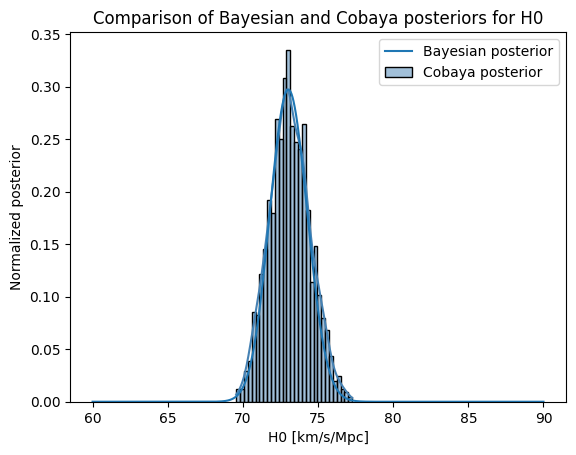

In [120]:
import seaborn as sns

plt.figure()

hist_H0 = sns.histplot(samples['H0'], bins=30, kde=True, stat="density", color="steelblue", alpha=0.5, label="Cobaya posterior")

scale_factor_H0 = hist_H0.get_lines()[0].get_ydata().max() / H0_Bayesian_posterior.max()
plt.plot(H0_array, H0_Bayesian_posterior * scale_factor_H0, label="Bayesian posterior")

plt.xlabel('H0 [km/s/Mpc]')
plt.ylabel('Normalized posterior')
plt.title('Comparison of Bayesian and Cobaya posteriors for H0')
plt.legend()
plt.show()

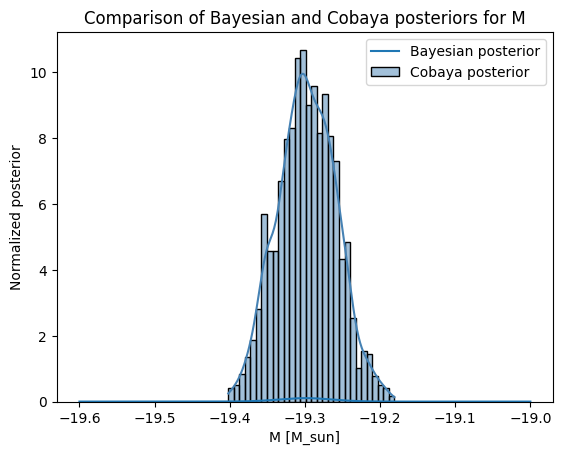

In [122]:
plt.figure()

hist_M = sns.histplot(samples['M'], bins=30, kde=True, stat="density", color="steelblue", alpha=0.5, label="Cobaya posterior")

scale_factor_M = hist_H0.get_lines()[0].get_ydata().max() / H0_Bayesian_posterior.max()
plt.plot(M_array, M_Bayesian_posterior * scale_factor_M, label="Bayesian posterior")

plt.xlabel('M [M_sun]')
plt.ylabel('Normalized posterior')
plt.title('Comparison of Bayesian and Cobaya posteriors for M')
plt.legend()
plt.show()